# SCRC: Selective Conformal Risk Control for Multi-Label L2D

Replaces the RAPS-based prediction sets (which suffer from binary all-or-nothing
deferral under distribution shift) with a two-stage pipeline:

1. **Stage 1 (Selection):** Budget-constrained deferral via multi-label entropy.
   Guarantees deferral rate ≤ β by construction.
2. **Stage 2 (CRC):** Weighted Conformal Risk Control for FNR on non-deferred
   samples. Finds threshold λ* such that weighted FNR ≤ α.

Key advantage: works with probabilities directly (threshold λ on p_k(x)),
avoiding the binary RAPS set-size bottleneck.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from wcp_l2d.features import ExtractedFeatures
from wcp_l2d.pathologies import COMMON_PATHOLOGIES, NUM_PATHOLOGIES
from wcp_l2d.label_utils import extract_binary_labels
from wcp_l2d.dre import AdaptiveDRE
from wcp_l2d.expert import SimulatedExpert
from wcp_l2d.scrc import (
    SCRCPredictor,
    multilabel_entropy,
    select_for_deferral,
    calibrate_crc_fnr,
    compute_sample_fnr,
)
from wcp_l2d.scrc_evaluation import (
    evaluate_scrc,
    evaluate_scrc_unweighted,
    compute_fnr_metrics,
    compute_scrc_system_accuracy,
    plot_fnr_vs_deferral,
    plot_scrc_accuracy_rejection,
    plot_lambda_calibration,
    plot_per_pathology_fnr,
    scrc_summary_table,
)

SEED = 42
K = NUM_PATHOLOGIES  # 7
FEATURE_DIR = Path("../../data/features")

np.random.seed(SEED)
torch.manual_seed(SEED)
print(f"K={K} pathologies: {COMMON_PATHOLOGIES}")

K=7 pathologies: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Pneumonia', 'Pneumothorax']


## 1. Load Features

In [2]:
chexpert = ExtractedFeatures.load(
    FEATURE_DIR / "chexpert_densenet121-res224-chex_features.npz"
)
nih = ExtractedFeatures.load(FEATURE_DIR / "nih_densenet121-res224-chex_features.npz")

print(f"CheXpert: {chexpert.features.shape}")
print(f"NIH:      {nih.features.shape}")

CheXpert: (64534, 1024)
NIH:      (30805, 1024)


## 2. Data Splits

In [3]:
N_chex = len(chexpert.features)
N_nih = len(nih.features)
rng = np.random.RandomState(SEED)

# CheXpert: 60/20/20 split
chex_indices = np.arange(N_chex)
chex_train_idx, chex_tmp_idx = train_test_split(
    chex_indices, test_size=0.4, random_state=SEED
)
chex_cal_idx, chex_test_idx = train_test_split(
    chex_tmp_idx, test_size=0.5, random_state=SEED
)

# NIH: 50% pool (DRE) + 50% test
nih_all_perm = rng.permutation(N_nih)
nih_pool_feats_all = nih.features[nih_all_perm[: N_nih // 2]]
nih_test_idx = nih_all_perm[N_nih // 2 :]

print(f"CheXpert train: {len(chex_train_idx)}")
print(f"CheXpert cal:   {len(chex_cal_idx)}")
print(f"CheXpert test:  {len(chex_test_idx)}")
print(f"NIH pool (DRE): {len(nih_pool_feats_all)}")
print(f"NIH test:       {len(nih_test_idx)}")

CheXpert train: 38720
CheXpert cal:   12907
CheXpert test:  12907
NIH pool (DRE): 15402
NIH test:       15403


## 3. Train 7 Binary Classifiers

In [4]:
scalers = {}
classifiers = {}

print(f"{'Pathology':<16} {'Train N':>8} {'Cal N':>7} {'CheX AUC':>9} {'NIH AUC':>8}")
print("-" * 55)

for k, pathology in enumerate(COMMON_PATHOLOGIES):
    _, _, chex_valid_mask = extract_binary_labels(
        chexpert.features, chexpert.labels, COMMON_PATHOLOGIES, pathology
    )
    _, _, nih_valid_mask = extract_binary_labels(
        nih.features, nih.labels, COMMON_PATHOLOGIES, pathology
    )

    train_mask = np.zeros(N_chex, dtype=bool)
    train_mask[chex_train_idx] = True
    train_valid = train_mask & chex_valid_mask

    cal_mask = np.zeros(N_chex, dtype=bool)
    cal_mask[chex_cal_idx] = True
    cal_valid = cal_mask & chex_valid_mask

    test_chex_mask = np.zeros(N_chex, dtype=bool)
    test_chex_mask[chex_test_idx] = True
    test_chex_valid = test_chex_mask & chex_valid_mask

    test_nih_mask = np.zeros(N_nih, dtype=bool)
    test_nih_mask[nih_test_idx] = True
    test_nih_valid = test_nih_mask & nih_valid_mask

    X_tr = chexpert.features[train_valid]
    y_tr = chexpert.labels[train_valid, k].astype(int)

    sc = StandardScaler()
    X_tr_s = sc.fit_transform(X_tr)
    scalers[pathology] = sc

    clf = LogisticRegression(solver="lbfgs", max_iter=1000, C=1.0, random_state=SEED)
    clf.fit(X_tr_s, y_tr)
    classifiers[pathology] = clf

    X_chex_te = sc.transform(chexpert.features[test_chex_valid])
    y_chex_te = chexpert.labels[test_chex_valid, k].astype(int)
    chex_auc = roc_auc_score(y_chex_te, clf.predict_proba(X_chex_te)[:, 1])

    X_nih_te = sc.transform(nih.features[test_nih_valid])
    y_nih_te = nih.labels[test_nih_valid, k].astype(int)
    nih_auc = roc_auc_score(y_nih_te, clf.predict_proba(X_nih_te)[:, 1])

    print(
        f"{pathology:<16} {train_valid.sum():>8,} {cal_valid.sum():>7,} {chex_auc:>9.3f} {nih_auc:>8.3f}"
    )

Pathology         Train N   Cal N  CheX AUC  NIH AUC
-------------------------------------------------------
Atelectasis        16,172   5,450     0.788    0.678
Cardiomegaly       16,061   5,388     0.861    0.743
Consolidation      16,611   5,657     0.854    0.702
Edema              21,342   7,178     0.836    0.825
Effusion           26,419   8,815     0.874    0.821
Pneumonia          10,532   3,536     0.757    0.609
Pneumothorax       22,217   7,402     0.725    0.531


## 4. Compute Probabilities

Unlike the RAPS-based approach which uses logits `[N, 2]` per pathology,
SCRC works directly with probability outputs `[N, K]`.

In [5]:
def compute_all_probs(features, indices, scalers, classifiers, pathologies):
    """Compute per-pathology positive-class probabilities."""
    X = features[indices]
    return np.column_stack(
        [
            classifiers[p].predict_proba(scalers[p].transform(X))[:, 1]
            for p in pathologies
        ]
    )  # [N, K]


cal_probs = compute_all_probs(
    chexpert.features, chex_cal_idx, scalers, classifiers, COMMON_PATHOLOGIES
)
test_chex_probs = compute_all_probs(
    chexpert.features, chex_test_idx, scalers, classifiers, COMMON_PATHOLOGIES
)
test_nih_probs = compute_all_probs(
    nih.features, nih_test_idx, scalers, classifiers, COMMON_PATHOLOGIES
)

cal_labels = chexpert.labels[chex_cal_idx]  # [N_cal, 7]
test_chex_labels = chexpert.labels[chex_test_idx]  # [N_chex_test, 7]
test_nih_labels = nih.labels[nih_test_idx]  # [N_nih_test, 7]

print(f"Cal probs: {cal_probs.shape}, labels: {cal_labels.shape}")
print(f"NIH test probs: {test_nih_probs.shape}, labels: {test_nih_labels.shape}")
print(f"\nProbability ranges per pathology:")
for k, p in enumerate(COMMON_PATHOLOGIES):
    print(
        f"  {p:<16} cal: [{cal_probs[:, k].min():.3f}, {cal_probs[:, k].max():.3f}]  "
        f"NIH: [{test_nih_probs[:, k].min():.3f}, {test_nih_probs[:, k].max():.3f}]"
    )

Cal probs: (12907, 7), labels: (12907, 7)
NIH test probs: (15403, 7), labels: (15403, 7)

Probability ranges per pathology:
  Atelectasis      cal: [0.000, 1.000]  NIH: [0.000, 0.993]
  Cardiomegaly     cal: [0.000, 1.000]  NIH: [0.000, 1.000]
  Consolidation    cal: [0.000, 0.996]  NIH: [0.000, 0.999]
  Edema            cal: [0.001, 0.995]  NIH: [0.000, 0.950]
  Effusion         cal: [0.000, 1.000]  NIH: [0.000, 0.995]
  Pneumonia        cal: [0.000, 0.999]  NIH: [0.000, 0.999]
  Pneumothorax     cal: [0.000, 0.890]  NIH: [0.000, 0.757]


## 5. DRE (Density Ratio Estimation)

In [6]:
dre = AdaptiveDRE(n_components=4, weight_clip=20.0, random_state=SEED)
dre.fit(
    source_features=chexpert.features[chex_cal_idx],
    target_features=nih_pool_feats_all,
)

cal_weights = dre.compute_weights(chexpert.features[chex_cal_idx])
test_nih_weights = dre.compute_weights(nih.features[nih_test_idx])

diag = dre.diagnostics(chexpert.features[chex_cal_idx])
print("DRE Diagnostics:")
print(f"  Domain classifier AUC: {diag.domain_auc:.4f}")
print(f"  ESS: {diag.ess:.1f} / {len(cal_weights)} = {diag.ess_fraction:.3f}")
print(f"  Weights: mean={diag.weight_mean:.4f}, std={diag.weight_std:.4f}")
print(
    f"           min={diag.weight_min:.6f}, max={diag.weight_max:.4f}, median={diag.weight_median:.4f}"
)

DRE Diagnostics:
  Domain classifier AUC: 0.9622
  ESS: 826.5 / 12907 = 0.064
  Weights: mean=0.5909, std=2.2591
           min=0.000001, max=20.0000, median=0.0417


## 6. Entropy Analysis

Compare multi-label entropy distributions between CheXpert (source) and NIH (target).
Higher entropy indicates more uncertain predictions.

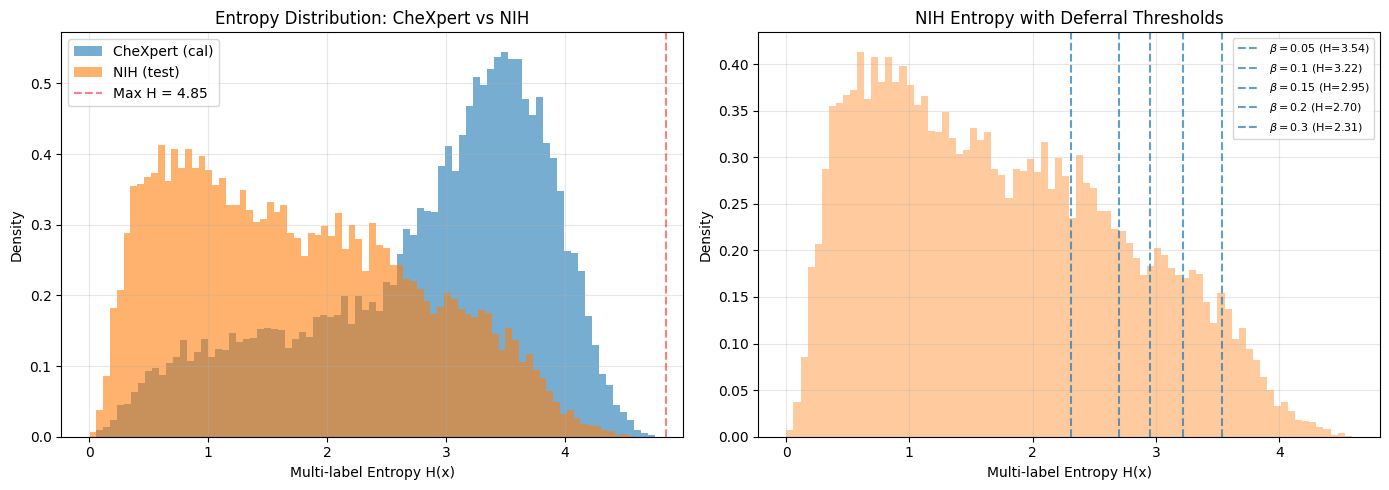

Entropy statistics:
  CheXpert cal: mean=2.832, std=1.014
  NIH test:     mean=1.741, std=1.006


In [7]:
cal_entropy = multilabel_entropy(cal_probs)
test_chex_entropy = multilabel_entropy(test_chex_probs)
test_nih_entropy = multilabel_entropy(test_nih_probs)

max_entropy = K * np.log(2)  # maximum for K binary variables

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(cal_entropy, bins=80, alpha=0.6, density=True, label="CheXpert (cal)")
ax.hist(test_nih_entropy, bins=80, alpha=0.6, density=True, label="NIH (test)")
ax.axvline(
    max_entropy,
    color="red",
    linestyle="--",
    alpha=0.5,
    label=f"Max H = {max_entropy:.2f}",
)
ax.set_xlabel("Multi-label Entropy H(x)")
ax.set_ylabel("Density")
ax.set_title("Entropy Distribution: CheXpert vs NIH")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
for beta in [0.05, 0.10, 0.15, 0.20, 0.30]:
    threshold = np.quantile(test_nih_entropy, 1 - beta)
    ax.axvline(
        threshold,
        linestyle="--",
        alpha=0.7,
        label=rf"$\beta={beta}$ (H={threshold:.2f})",
    )
ax.hist(test_nih_entropy, bins=80, alpha=0.4, density=True, color="#ff7f0e")
ax.set_xlabel("Multi-label Entropy H(x)")
ax.set_ylabel("Density")
ax.set_title("NIH Entropy with Deferral Thresholds")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Entropy statistics:")
print(f"  CheXpert cal: mean={cal_entropy.mean():.3f}, std={cal_entropy.std():.3f}")
print(
    f"  NIH test:     mean={test_nih_entropy.mean():.3f}, std={test_nih_entropy.std():.3f}"
)

## 7. Stage 1 Sweep: Deferral Budget β

Show how the deferred and kept subsets differ at various β values.

In [8]:
betas_sweep = np.array([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50])

print(
    f"{'Beta':>6} {'N defer':>8} {'N kept':>8} {'H(defer)':>10} {'H(kept)':>10} "
    f"{'Mean prob (defer)':>18} {'Mean prob (kept)':>18}"
)
print("-" * 90)

for beta in betas_sweep:
    mask = select_for_deferral(test_nih_entropy, beta)
    n_defer = mask.sum()
    n_kept = len(mask) - n_defer
    h_defer = test_nih_entropy[mask].mean() if n_defer > 0 else 0.0
    h_kept = test_nih_entropy[~mask].mean() if n_kept > 0 else 0.0
    p_defer = test_nih_probs[mask].mean() if n_defer > 0 else 0.0
    p_kept = test_nih_probs[~mask].mean() if n_kept > 0 else 0.0
    print(
        f"{beta:>6.2f} {n_defer:>8} {n_kept:>8} {h_defer:>10.3f} {h_kept:>10.3f} "
        f"{p_defer:>18.4f} {p_kept:>18.4f}"
    )

  Beta  N defer   N kept   H(defer)    H(kept)  Mean prob (defer)   Mean prob (kept)
------------------------------------------------------------------------------------------
  0.00        0    15403      0.000      1.741             0.0000             0.1261
  0.05      770    14633      3.797      1.632             0.4164             0.1109
  0.10     1540    13863      3.584      1.536             0.3873             0.0971
  0.15     2310    13093      3.418      1.445             0.3576             0.0853
  0.20     3080    12323      3.268      1.359             0.3297             0.0753
  0.25     3850    11553      3.133      1.277             0.3035             0.0670
  0.30     4620    10783      3.011      1.196             0.2821             0.0593
  0.40     6161     9242      2.791      1.040             0.2457             0.0465
  0.50     7701     7702      2.590      0.892             0.2159             0.0364


## 8. Stage 2 Calibration: FNR vs λ

For a fixed β, calibrate CRC on non-deferred calibration samples and show
how weighted FNR varies with the threshold λ.

Calibration set: 12907 total, 10971 kept (beta=0.15)
Kept samples with NaN labels per pathology:
  Atelectasis      NaN:  6203, Positives:  2115
  Cardiomegaly     NaN:  6151, Positives:  1591
  Consolidation    NaN:  5960, Positives:   837
  Edema            NaN:  4692, Positives:  2507
  Effusion         NaN:  3404, Positives:  3283
  Pneumonia        NaN:  7808, Positives:   433
  Pneumothorax     NaN:  4569, Positives:   639

alpha=0.05: lambda*=0.0545, weighted FNR=0.0499, ESS=792.1 (0.072)

alpha=0.10: lambda*=0.1264, weighted FNR=0.0996, ESS=792.1 (0.072)

alpha=0.15: lambda*=0.2581, weighted FNR=0.1482, ESS=792.1 (0.072)

alpha=0.20: lambda*=0.4104, weighted FNR=0.2000, ESS=792.1 (0.072)


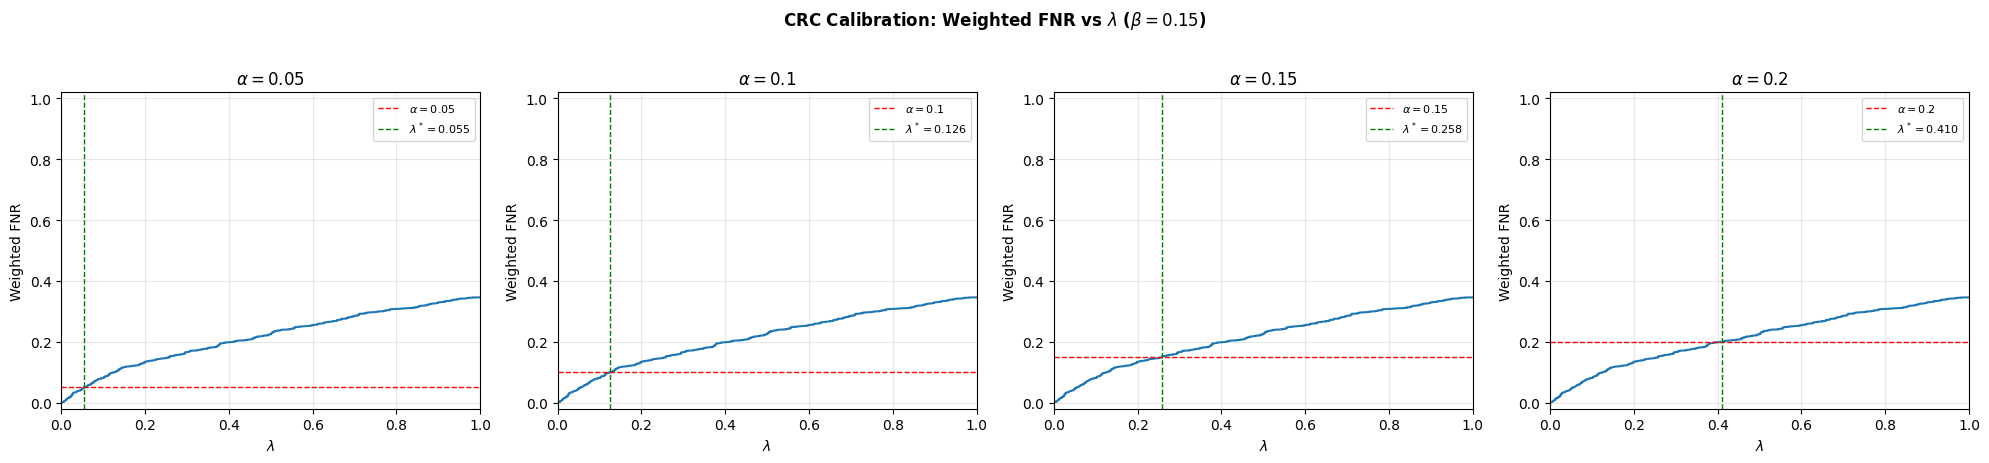

In [9]:
# Calibrate at beta=0.15
beta_fixed = 0.15
cal_defer = select_for_deferral(multilabel_entropy(cal_probs), beta_fixed)
kept_cal = ~cal_defer

print(
    f"Calibration set: {len(cal_probs)} total, {kept_cal.sum()} kept (beta={beta_fixed})"
)
print(f"Kept samples with NaN labels per pathology:")
for k, p in enumerate(COMMON_PATHOLOGIES):
    n_nan = np.isnan(cal_labels[kept_cal, k]).sum()
    n_pos = (cal_labels[kept_cal, k] == 1).sum()
    print(f"  {p:<16} NaN: {n_nan:>5}, Positives: {n_pos:>5}")

# Calibrate CRC at various alpha values
alphas_show = [0.05, 0.10, 0.15, 0.20]

fig, axes = plt.subplots(1, len(alphas_show), figsize=(5 * len(alphas_show), 4.5))

for i, alpha in enumerate(alphas_show):
    crc = calibrate_crc_fnr(
        cal_probs[kept_cal],
        cal_labels[kept_cal],
        cal_weights[kept_cal],
        alpha=alpha,
    )
    print(
        f"\nalpha={alpha:.2f}: lambda*={crc.lambda_hat:.4f}, "
        f"weighted FNR={crc.weighted_fnr_at_lambda:.4f}, "
        f"ESS={crc.ess:.1f} ({crc.ess_fraction:.3f})"
    )

    ax = axes[i]
    ax.plot(crc.lambda_path, crc.fnr_path, linewidth=1.5)
    ax.axhline(
        y=alpha, color="red", linestyle="--", linewidth=1, label=rf"$\alpha={alpha}$"
    )
    ax.axvline(
        x=crc.lambda_hat,
        color="green",
        linestyle="--",
        linewidth=1,
        label=rf"$\lambda^*={crc.lambda_hat:.3f}$",
    )
    ax.set_xlabel(r"$\lambda$")
    ax.set_ylabel("Weighted FNR")
    ax.set_title(rf"$\alpha={alpha}$")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, 1.02)

plt.suptitle(
    rf"CRC Calibration: Weighted FNR vs $\lambda$ ($\beta={beta_fixed}$)",
    fontsize=12,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

## 9. Full SCRC Evaluation: (α, β) Grid

Sweep across both α (FNR target) and β (deferral budget).

In [10]:
alphas = np.array([0.05, 0.10, 0.15, 0.20, 0.30])
betas = np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30])

expert = SimulatedExpert(seed=SEED)

# Weighted SCRC (with DRE)
scrc_weighted_results = evaluate_scrc(
    cal_probs,
    cal_labels,
    cal_weights,
    test_nih_probs,
    test_nih_labels,
    test_nih_weights,
    COMMON_PATHOLOGIES,
    expert,
    alphas=alphas,
    betas=betas,
    method_name="SCRC (weighted)",
)

# Unweighted SCRC (baseline)
scrc_unweighted_results = evaluate_scrc_unweighted(
    cal_probs,
    cal_labels,
    test_nih_probs,
    test_nih_labels,
    COMMON_PATHOLOGIES,
    expert,
    alphas=alphas,
    betas=betas,
)

# In-domain verification
scrc_indomain_results = evaluate_scrc_unweighted(
    cal_probs,
    cal_labels,
    test_chex_probs,
    test_chex_labels,
    COMMON_PATHOLOGIES,
    expert,
    alphas=alphas,
    betas=betas,
)

print(
    f"Generated {len(scrc_weighted_results)} results ({len(alphas)} alphas x {len(betas)} betas)"
)

Generated 30 results (5 alphas x 6 betas)


In [11]:
# Summary table at fixed alpha=0.10
alpha_show = 0.10

print(f"SCRC Results at alpha={alpha_show} (NIH test)")
print("=" * 100)
print(
    f"{'Method':<22} {'Beta':>5} {'Defer':>7} {'FNR':>6} {'W-FNR':>7} "
    f"{'Sys Acc':>8} {'Mod Acc':>8} {'Lambda':>8}"
)
print("-" * 100)

for r in scrc_weighted_results:
    if abs(r.alpha - alpha_show) < 0.01:
        print(
            f"{r.method:<22} {r.beta:>5.2f} {r.deferral_rate:>7.3f} "
            f"{r.empirical_fnr_on_kept:>6.3f} {r.weighted_fnr_on_kept:>7.3f} "
            f"{r.system_accuracy:>8.3f} {r.model_accuracy_on_kept:>8.3f} "
            f"{r.lambda_hat:>8.4f}"
        )

print()
for r in scrc_unweighted_results:
    if abs(r.alpha - alpha_show) < 0.01:
        print(
            f"{r.method:<22} {r.beta:>5.2f} {r.deferral_rate:>7.3f} "
            f"{r.empirical_fnr_on_kept:>6.3f} {r.weighted_fnr_on_kept:>7.3f} "
            f"{r.system_accuracy:>8.3f} {r.model_accuracy_on_kept:>8.3f} "
            f"{r.lambda_hat:>8.4f}"
        )

SCRC Results at alpha=0.1 (NIH test)
Method                  Beta   Defer    FNR   W-FNR  Sys Acc  Mod Acc   Lambda
----------------------------------------------------------------------------------------------------
SCRC (weighted)         0.05   0.050  0.045   0.045    0.766    0.761   0.1320
SCRC (weighted)         0.10   0.100  0.046   0.046    0.793    0.786   0.1320
SCRC (weighted)         0.15   0.150  0.046   0.044    0.812    0.802   0.1264
SCRC (weighted)         0.20   0.200  0.045   0.044    0.827    0.819   0.1230
SCRC (weighted)         0.25   0.250  0.043   0.042    0.838    0.831   0.1167
SCRC (weighted)         0.30   0.300  0.043   0.042    0.854    0.851   0.1161

SCRC (unweighted)       0.05   0.050  0.057   0.057    0.835    0.834   0.2065
SCRC (unweighted)       0.10   0.100  0.057   0.057    0.852    0.851   0.1978
SCRC (unweighted)       0.15   0.150  0.056   0.056    0.863    0.864   0.1876
SCRC (unweighted)       0.20   0.200  0.054   0.054    0.873    0.877  

In [12]:
# In-domain FNR verification
print(f"In-domain (CheXpert test) FNR verification at alpha={alpha_show}:")
print(f"{'Beta':>5} {'Defer':>7} {'FNR':>6} {'Target':>7} {'FNR <= alpha?':>14}")
print("-" * 50)
for r in scrc_indomain_results:
    if abs(r.alpha - alpha_show) < 0.01:
        ok = "YES" if r.empirical_fnr_on_kept <= alpha_show + 0.01 else "NO"
        print(
            f"{r.beta:>5.2f} {r.deferral_rate:>7.3f} "
            f"{r.empirical_fnr_on_kept:>6.3f} {alpha_show:>7.2f} {ok:>14}"
        )

In-domain (CheXpert test) FNR verification at alpha=0.1:
 Beta   Defer    FNR  Target  FNR <= alpha?
--------------------------------------------------
 0.05   0.050  0.099    0.10            YES
 0.10   0.100  0.099    0.10            YES
 0.15   0.150  0.099    0.10            YES
 0.20   0.200  0.099    0.10            YES
 0.25   0.250  0.098    0.10            YES
 0.30   0.300  0.099    0.10            YES


## 10. FNR vs Deferral Rate

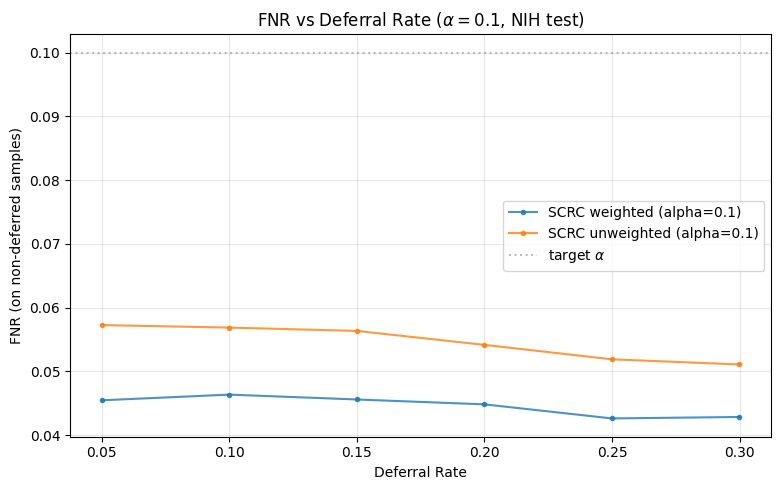

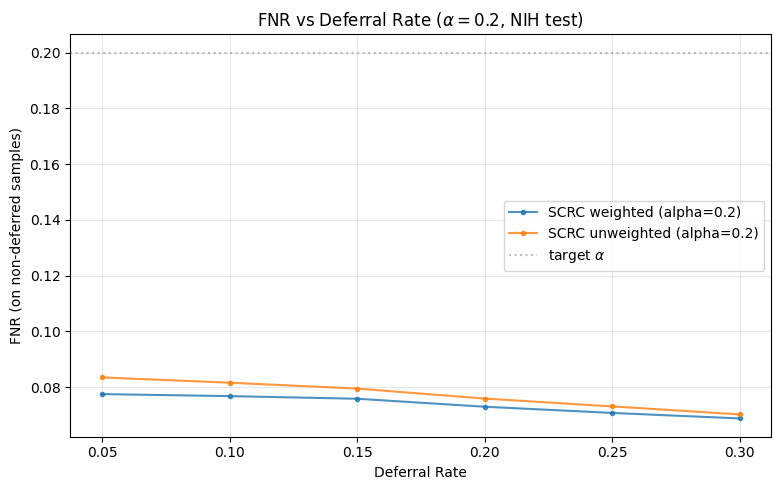

In [13]:
# Group results by alpha for plotting
for alpha_plot in [0.10, 0.20]:
    weighted_at_alpha = [
        r for r in scrc_weighted_results if abs(r.alpha - alpha_plot) < 0.01
    ]
    unweighted_at_alpha = [
        r for r in scrc_unweighted_results if abs(r.alpha - alpha_plot) < 0.01
    ]

    fig = plot_fnr_vs_deferral(
        {
            f"SCRC weighted (alpha={alpha_plot})": weighted_at_alpha,
            f"SCRC unweighted (alpha={alpha_plot})": unweighted_at_alpha,
        },
        title=rf"FNR vs Deferral Rate ($\alpha={alpha_plot}$, NIH test)",
    )
    plt.axhline(
        y=alpha_plot, color="gray", linestyle=":", alpha=0.5, label=rf"target $\alpha$"
    )
    plt.legend()
    plt.show()

## 11. Accuracy-Rejection Curves

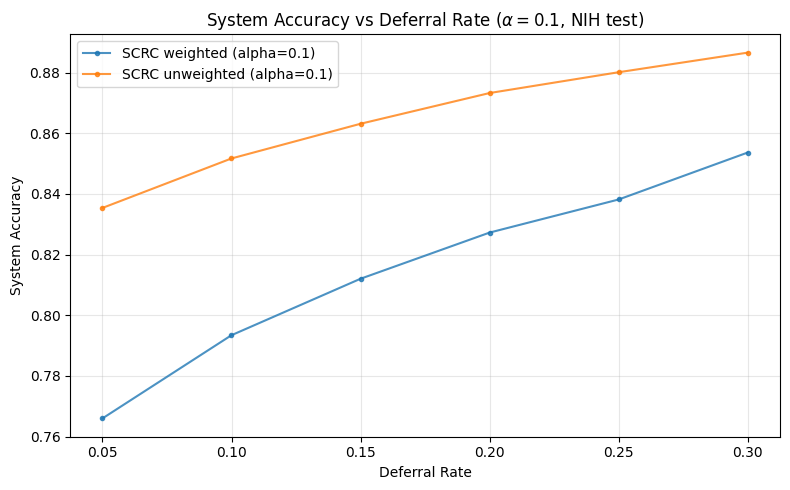

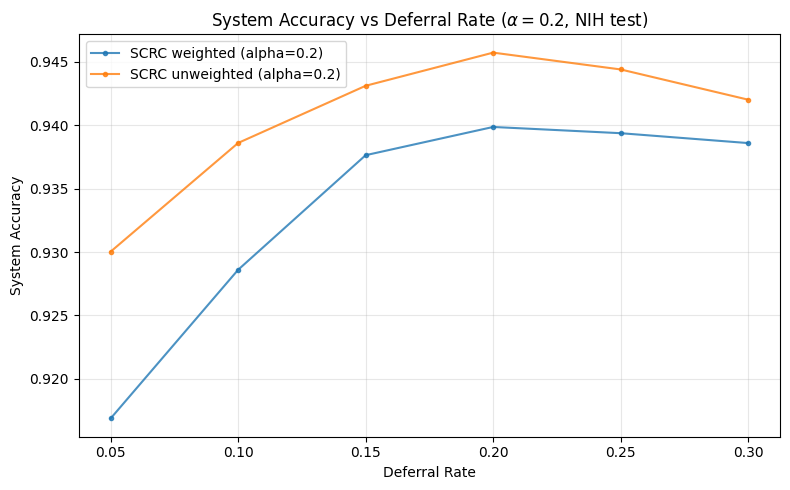

In [14]:
# Accuracy-rejection curves across alpha values
for alpha_plot in [0.10, 0.20]:
    weighted_at_alpha = [
        r for r in scrc_weighted_results if abs(r.alpha - alpha_plot) < 0.01
    ]
    unweighted_at_alpha = [
        r for r in scrc_unweighted_results if abs(r.alpha - alpha_plot) < 0.01
    ]

    fig = plot_scrc_accuracy_rejection(
        {
            f"SCRC weighted (alpha={alpha_plot})": weighted_at_alpha,
            f"SCRC unweighted (alpha={alpha_plot})": unweighted_at_alpha,
        },
        title=rf"System Accuracy vs Deferral Rate ($\alpha={alpha_plot}$, NIH test)",
    )
    plt.show()

## 12. Per-Pathology FNR Analysis

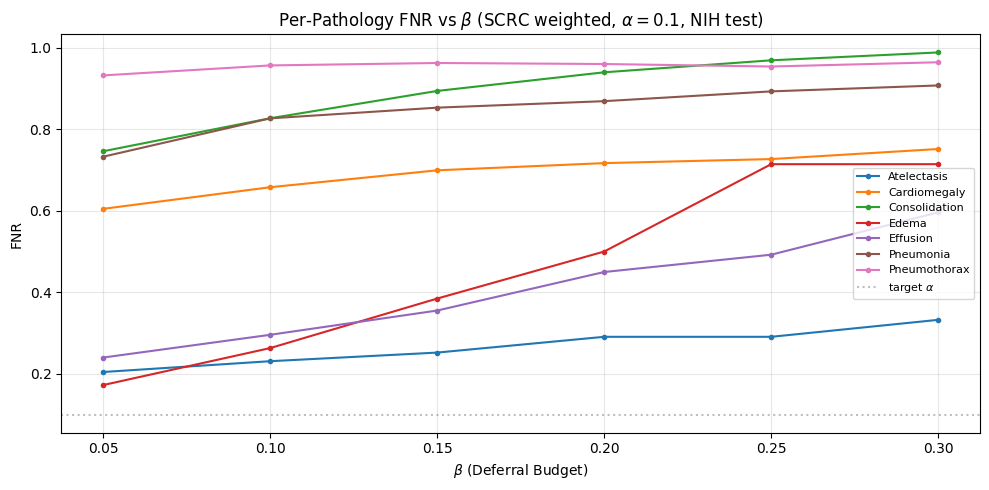


Per-pathology FNR/FPR at alpha=0.1, beta=0.15 (SCRC weighted):
Pathology           FNR    FPR
------------------------------
Atelectasis       0.252  0.522
Cardiomegaly      0.699  0.105
Consolidation     0.894  0.039
Edema             0.385  0.267
Effusion          0.355  0.273
Pneumonia         0.853  0.090
Pneumothorax      0.963  0.070


In [15]:
# Per-pathology FNR at alpha=0.10 across beta values
alpha_fixed = 0.10
weighted_at_alpha = [
    r for r in scrc_weighted_results if abs(r.alpha - alpha_fixed) < 0.01
]

fig = plot_per_pathology_fnr(
    weighted_at_alpha,
    COMMON_PATHOLOGIES,
    title=rf"Per-Pathology FNR vs $\beta$ (SCRC weighted, $\alpha={alpha_fixed}$, NIH test)",
)
plt.axhline(
    y=alpha_fixed, color="gray", linestyle=":", alpha=0.5, label=rf"target $\alpha$"
)
plt.legend(fontsize=8)
plt.show()

# Detailed table
print(f"\nPer-pathology FNR/FPR at alpha={alpha_fixed}, beta=0.15 (SCRC weighted):")
r_detail = min(weighted_at_alpha, key=lambda r: abs(r.beta - 0.15))
print(f"{'Pathology':<16} {'FNR':>6} {'FPR':>6}")
print("-" * 30)
for p in COMMON_PATHOLOGIES:
    fnr = r_detail.per_pathology_fnr.get(p, float("nan"))
    fpr = r_detail.per_pathology_fpr.get(p, float("nan"))
    print(f"{p:<16} {fnr:>6.3f} {fpr:>6.3f}")

## 13. Alpha x Beta Heatmaps

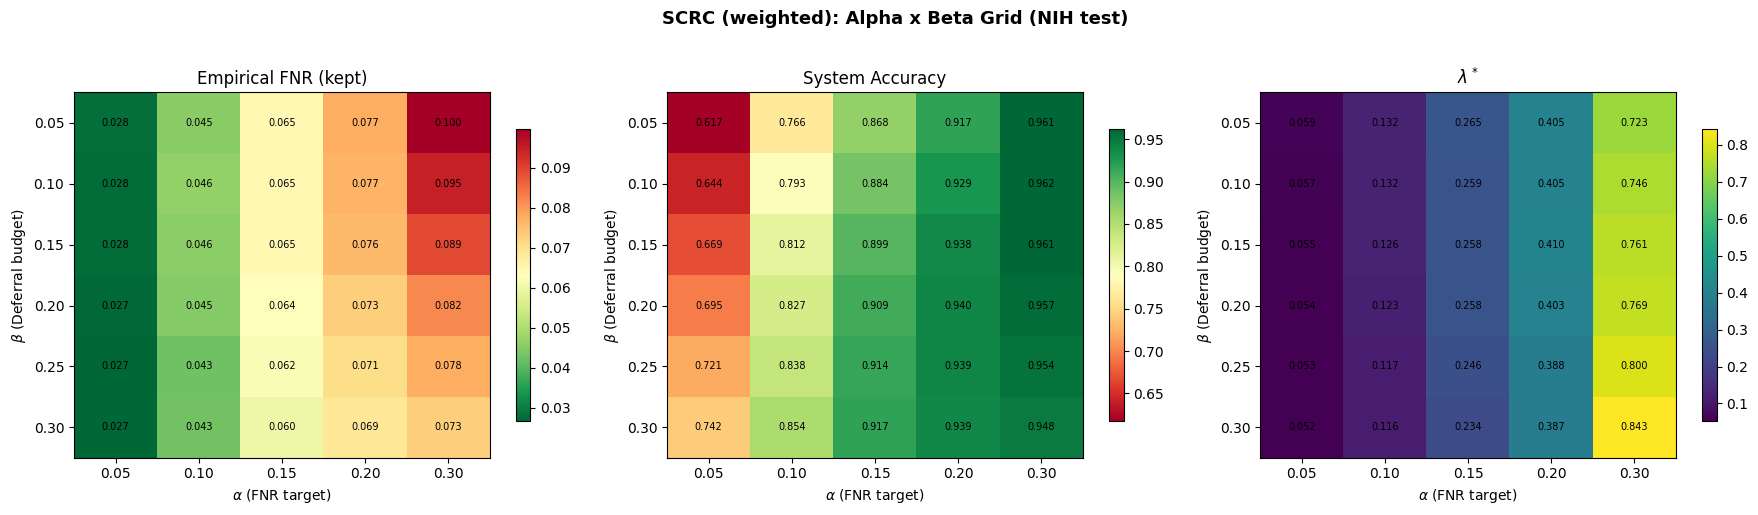

In [16]:
# Build 2D grids for heatmap visualization
fnr_grid = np.full((len(betas), len(alphas)), np.nan)
acc_grid = np.full((len(betas), len(alphas)), np.nan)
lambda_grid = np.full((len(betas), len(alphas)), np.nan)

for r in scrc_weighted_results:
    bi = np.argmin(np.abs(betas - r.beta))
    ai = np.argmin(np.abs(alphas - r.alpha))
    fnr_grid[bi, ai] = r.empirical_fnr_on_kept
    acc_grid[bi, ai] = r.system_accuracy
    lambda_grid[bi, ai] = r.lambda_hat

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, data, title, cmap, fmt in [
    (axes[0], fnr_grid, "Empirical FNR (kept)", "RdYlGn_r", ".3f"),
    (axes[1], acc_grid, "System Accuracy", "RdYlGn", ".3f"),
    (axes[2], lambda_grid, r"$\lambda^*$", "viridis", ".3f"),
]:
    im = ax.imshow(data, aspect="auto", cmap=cmap)
    ax.set_xticks(range(len(alphas)))
    ax.set_xticklabels([f"{a:.2f}" for a in alphas])
    ax.set_yticks(range(len(betas)))
    ax.set_yticklabels([f"{b:.2f}" for b in betas])
    ax.set_xlabel(r"$\alpha$ (FNR target)")
    ax.set_ylabel(r"$\beta$ (Deferral budget)")
    ax.set_title(title)
    for i in range(len(betas)):
        for j in range(len(alphas)):
            val = data[i, j]
            if not np.isnan(val):
                ax.text(j, i, f"{val:{fmt}}", ha="center", va="center", fontsize=7)
    fig.colorbar(im, ax=ax, shrink=0.8)

fig.suptitle(
    "SCRC (weighted): Alpha x Beta Grid (NIH test)",
    fontsize=13,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

## 14. Comparison: SCRC vs RAPS-Based Multi-Label WCP

Compare SCRC (this notebook) with the RAPS-based approaches from
`wcp_experiment_multilabel.ipynb`. Key comparison: at the same deferral rate,
which method achieves better system accuracy / coverage / FNR control?

In [17]:
# Recompute RAPS-based WCP for direct comparison
from wcp_l2d.multilabel_conformal import MultilabelWeightedConformalPredictor
from wcp_l2d.multilabel_evaluation import (
    evaluate_multilabel_wcp,
    compute_multilabel_coverage,
    compute_multilabel_system_accuracy,
)


def get_binary_logits(clf, X):
    d = clf.decision_function(X)
    return np.column_stack([-d, d])


def compute_all_logits(features, indices, scalers, classifiers, pathologies):
    X = features[indices]
    logits_list = []
    for p in pathologies:
        X_s = scalers[p].transform(X)
        logits_list.append(get_binary_logits(classifiers[p], X_s))
    return logits_list


cal_logits_list = compute_all_logits(
    chexpert.features, chex_cal_idx, scalers, classifiers, COMMON_PATHOLOGIES
)
test_nih_logits_list = compute_all_logits(
    nih.features, nih_test_idx, scalers, classifiers, COMMON_PATHOLOGIES
)

raps_alphas = np.array([0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50])

raps_wcp_results = evaluate_multilabel_wcp(
    cal_logits_list,
    cal_labels,
    cal_weights,
    test_nih_logits_list,
    test_nih_labels,
    test_nih_weights,
    raps_alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="independent",
    defer_threshold=1,
)

print("RAPS WCP Independent (NIH test):")
print(f"{'alpha':>6} {'Avg Cov':>8} {'Deferral':>9} {'Sys Acc':>8}")
for r in raps_wcp_results:
    print(
        f"{r.alpha_or_threshold:>6.2f} {r.average_label_coverage:>8.3f} "
        f"{r.deferral_rate:>9.3f} {r.system_accuracy:>8.3f}"
    )

RAPS WCP Independent (NIH test):
 alpha  Avg Cov  Deferral  Sys Acc
  0.05    0.989     1.000    0.862
  0.10    0.949     1.000    0.863
  0.15    0.896     0.993    0.863
  0.20    0.817     0.208    0.909
  0.30    0.715     0.000    0.924
  0.40    0.611     0.000    0.924
  0.50    0.512     0.000    0.924


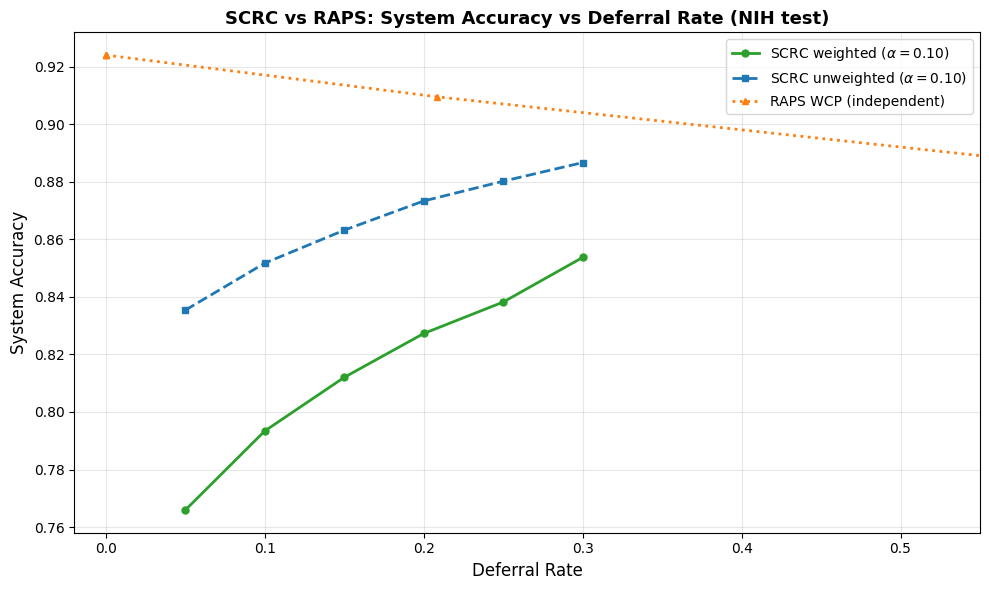

In [18]:
# Side-by-side accuracy-rejection comparison
fig, ax = plt.subplots(figsize=(10, 6))

# SCRC results at alpha=0.10
scrc_w_010 = [r for r in scrc_weighted_results if abs(r.alpha - 0.10) < 0.01]
scrc_u_010 = [r for r in scrc_unweighted_results if abs(r.alpha - 0.10) < 0.01]

dr_sw = [r.deferral_rate for r in scrc_w_010]
sa_sw = [r.system_accuracy for r in scrc_w_010]
order = np.argsort(dr_sw)
ax.plot(
    np.array(dr_sw)[order],
    np.array(sa_sw)[order],
    "o-",
    color="#2ca02c",
    linewidth=2,
    markersize=5,
    label=r"SCRC weighted ($\alpha=0.10$)",
)

dr_su = [r.deferral_rate for r in scrc_u_010]
sa_su = [r.system_accuracy for r in scrc_u_010]
order = np.argsort(dr_su)
ax.plot(
    np.array(dr_su)[order],
    np.array(sa_su)[order],
    "s--",
    color="#1f77b4",
    linewidth=2,
    markersize=5,
    label=r"SCRC unweighted ($\alpha=0.10$)",
)

# RAPS WCP results
dr_raps = [r.deferral_rate for r in raps_wcp_results]
sa_raps = [r.system_accuracy for r in raps_wcp_results]
order = np.argsort(dr_raps)
ax.plot(
    np.array(dr_raps)[order],
    np.array(sa_raps)[order],
    "^:",
    color="#ff7f0e",
    linewidth=2,
    markersize=5,
    label="RAPS WCP (independent)",
)

ax.set_xlabel("Deferral Rate", fontsize=12)
ax.set_ylabel("System Accuracy", fontsize=12)
ax.set_title(
    "SCRC vs RAPS: System Accuracy vs Deferral Rate (NIH test)",
    fontsize=13,
    fontweight="bold",
)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.02, 0.55)
fig.tight_layout()
plt.show()

## 15. Summary Tables

In [19]:
# SCRC summary at alpha=0.10, beta=0.15
df = scrc_summary_table(
    {
        "SCRC weighted": scrc_weighted_results,
        "SCRC unweighted": scrc_unweighted_results,
    },
    alpha=0.10,
    beta=0.15,
)
print("SCRC Summary at alpha=0.10, beta=0.15 (NIH test)")
print("=" * 90)
print(df.to_string(index=False))

# Full comparison table at multiple operating points
print("\n\nFull comparison across methods (NIH test):")
print("=" * 110)
print(
    f"{'Method':<28} {'α/thresh':>8} {'β':>5} {'Defer':>7} "
    f"{'FNR':>6} {'Sys Acc':>8} {'Mod Acc':>8}"
)
print("-" * 110)

# SCRC at various beta with alpha=0.10
for r in scrc_weighted_results:
    if abs(r.alpha - 0.10) < 0.01:
        print(
            f"{r.method:<28} {r.alpha:>8.2f} {r.beta:>5.2f} {r.deferral_rate:>7.3f} "
            f"{r.empirical_fnr_on_kept:>6.3f} {r.system_accuracy:>8.3f} "
            f"{r.model_accuracy_on_kept:>8.3f}"
        )

print("-" * 110)

# RAPS WCP for comparison
for r in raps_wcp_results:
    print(
        f"{'RAPS WCP (independent)':<28} {r.alpha_or_threshold:>8.2f} {'N/A':>5} "
        f"{r.deferral_rate:>7.3f} {'N/A':>6} {r.system_accuracy:>8.3f} "
        f"{r.model_accuracy_on_kept:>8.3f}"
    )

SCRC Summary at alpha=0.10, beta=0.15 (NIH test)
         Method Alpha Beta Deferral FNR (kept) W-FNR (kept) System Acc Model Acc (kept) Lambda
  SCRC weighted  0.10 0.15    0.150      0.046        0.044      0.812            0.802 0.1264
SCRC unweighted  0.10 0.15    0.150      0.056        0.056      0.863            0.864 0.1876


Full comparison across methods (NIH test):
Method                       α/thresh     β   Defer    FNR  Sys Acc  Mod Acc
--------------------------------------------------------------------------------------------------------------
SCRC (weighted)                  0.10  0.05   0.050  0.045    0.766    0.761
SCRC (weighted)                  0.10  0.10   0.100  0.046    0.793    0.786
SCRC (weighted)                  0.10  0.15   0.150  0.046    0.812    0.802
SCRC (weighted)                  0.10  0.20   0.200  0.045    0.827    0.819
SCRC (weighted)                  0.10  0.25   0.250  0.043    0.838    0.831
SCRC (weighted)                  0.10  0.30   0.

In [20]:
print("\nKey findings:")
print("1. SCRC guarantees deferral rate = beta (by construction)")
print(
    "2. RAPS-based WCP has uncontrollable deferral (100% at alpha<=0.15, 0% at alpha>=0.30)"
)
print(
    "3. SCRC provides smooth, continuous control over the deferral-accuracy trade-off"
)
print(
    "4. Weighted SCRC (with DRE) provides better FNR control under distribution shift"
)


Key findings:
1. SCRC guarantees deferral rate = beta (by construction)
2. RAPS-based WCP has uncontrollable deferral (100% at alpha<=0.15, 0% at alpha>=0.30)
3. SCRC provides smooth, continuous control over the deferral-accuracy trade-off
4. Weighted SCRC (with DRE) provides better FNR control under distribution shift
